**In previous notebooks we cleaned and analysed the data and topics associated with the comments. Now we will use the cleaned and lemmatized data for modelling.**

## Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_roc_curve, classification_report

import pickle

from google.colab import drive

## Import Cleaned Data

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Capstone/Data/

In [ ]:
train = pd.read_csv("train_clean_lemmatize.csv")

/content/drive/My Drive/Capstone/Data


In [ ]:
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,comment_cleaned,comment_lemmatized,target_label
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,this is so cool it like would you want your mo...,cool like would want mother read realli great ...,0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,thank you this would make my life lot less anx...,thank would make life lot less anxieti induc k...,0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,this is such an urgent design problem kudos to...,urgent design problem kudo take impress,0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,is this something ll be able to install on my ...,someth abl instal site releas,0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,haha you guys are bunch of losers,haha guy bunch loser,1


In [ ]:
train.shape

(1778628, 35)

In [ ]:
train['target_label'].value_counts()

0    1636193
1     142435
Name: target_label, dtype: int64

We have imbalanced comments data, toxic comments being the minor class in comparision to the non toxic comments. 

## Declare Features & Target

Declaring the feature and target for models. We will use lemmatized comments for the base models to predict the toxic comments labelled in target_label.

In [ ]:
X = train['comment_lemmatized']
y = train['target_label']

## Train/Test Split

We will then split our data into train and validation set and stratify by y so that our subsets have equal distribution of the labels.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  stratify = y,
                                                  random_state = 42)

In [ ]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(1333971,) (1333971,) (444657,) (444657,)


In [ ]:
y_train.value_counts(normalize=True)

0    0.919919
1    0.080081
Name: target_label, dtype: float64

In [ ]:
y_val.value_counts(normalize=True)

0    0.919918
1    0.080082
Name: target_label, dtype: float64

Here we can see that the train and validation set have even distribution of the toxic and non toxic labels.



## Modelling

### Tokenize Using TfidVectorizer

Before modelling we need to convert the text comments into a feature matrix. The min_df, max_df and ngram_range has been selected after few trials.

In [ ]:
tfvec = TfidfVectorizer(min_df=5,  
                        max_df = 0.9,
                        ngram_range = (1,2))

In [ ]:
X_train_tfvec = tfvec.fit_transform(X_train)
X_val_tfvec = tfvec.transform(X_val)

### Model Function

In [ ]:
def create_model(model, params):
    '''
    Common function to use for modelling
    '''

    # Declaring model metrics that we will return at the end of the function
    metrics = {}

    # Initialize gridsearch for model based on params passed
    gs = GridSearchCV(model, param_grid=params, cv=5, scoring='roc_auc', n_jobs=-1)

    # Fit the model
    gs.fit(X_train_tfvec, y_train)

    # Best parameters
    best_params = gs.best_params_

    # Best model
    best_model = gs.best_estimator_

    # Fit the best model
    best_model.fit(X_train_tfvec, y_train)

    # Predic validation set
    predictions = best_model.predict(X_val_tfvec)

    # Metrics
    train_pred_prob = best_model.predict_proba(X_train_tfvec)[:,1]
    test_pred_prob = best_model.predict_proba(X_val_tfvec)[:,1]
    roc_auc_train = roc_auc_score(y_train, train_pred_prob)
    roc_auc_val = roc_auc_score(y_val, test_pred_prob)
    tn, fp, fn, tp = confusion_matrix(y_val, predictions).ravel()
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    accuracy = (tn + tp)/(tn + tp + fn + fp)
  
    metrics['roc_auc_train'] = roc_auc_train
    metrics['roc_auc_val'] = roc_auc_val
    metrics['accuracy'] = accuracy
    metrics['sensitivity'] = sensitivity
    metrics['specificity'] = specificity
    metrics['FalsePos'] = fp
    metrics['TruePos'] = tp
    metrics['FalseNeg'] = fn
    metrics['TrueNeg'] = tn
  
    return (best_params, best_model, metrics)

### Logistic Regression

In [ ]:
# Declare grid search parameters

lr_params = {
    'penalty':['l2','l1'], 
    'C': [0.8, 1],
    'max_iter':[3000],
    'random_state':[42]
}

lr_model = LogisticRegression()

lr_best_params, lr_best_model, lr_metrics = create_model(lr_model, params=lr_params)

print(lr_best_params)
print(lr_metrics)

{'C': 1, 'max_iter': 3000, 'penalty': 'l2', 'random_state': 42}
{'roc_auc_train': 0.9715131888730236, 'roc_auc_val': 0.945063386589076, 'accuracy': 0.9453174019525162, 'sensitivity': 0.43497430424892586, 'specificity': 0.9897444798654437, 'FalsePos': 4195, 'TruePos': 15489, 'FalseNeg': 20120, 'TrueNeg': 404853}


Saving the Logistic Regression model for future use.

In [ ]:
filename = '/content/drive/My Drive/Capstone/Code/BaseModels/LogisticRegression.pkl'
pickle.dump(lr_best_model, open(filename, 'wb'))

In [ ]:
#lr_best_model = pickle.load(open(filename, 'rb'))

In [ ]:
features = tfvec.get_feature_names()
features[:20]

['aa',
 'aa aa',
 'aa anoth',
 'aa bee',
 'aa degre',
 'aa group',
 'aa help',
 'aa html',
 'aa left',
 'aa meet',
 'aa na',
 'aa poor',
 'aa religi',
 'aa say',
 'aa stori',
 'aa usual',
 'aaa',
 'aaa anoth',
 'aaa bond',
 'aaa credit']

In [ ]:
feature_coef = pd.DataFrame({'Feature': tfvec.get_feature_names(), 'coef': lr_best_model.coef_[0]})

In [ ]:
pd.set_option('display.max_rows', None)
feature_coef.sort_values(by='coef', ascending=False).head(100)

,Feature,coef
976459,stupid,45.570819
481391,idiot,42.148934
731276,pathet,23.813259
478738,hypocrit,23.409914
231892,crap,21.993476
648985,moron,21.321607
295476,dumb,20.632807
383759,fool,19.567671
866157,ridicul,18.856028
243813,damn,18.822865


In [ ]:
np.max(lr_best_model.coef_[0])

45.570819491813836

In [ ]:
len(features)

1148538

<Figure size 1440x1080 with 0 Axes>

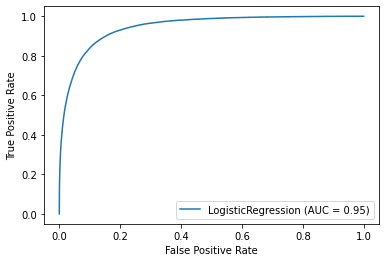

In [ ]:
plt.figure(figsize=(20,15))
lr_disp = plot_roc_curve(lr_best_model, X_val_tfvec, y_val)

In [ ]:
preds = lr_best_model.predict(X_val_tfvec)

In [ ]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97    409048
           1       0.79      0.43      0.56     35609

    accuracy                           0.95    444657
   macro avg       0.87      0.71      0.77    444657
weighted avg       0.94      0.95      0.94    444657



In [ ]:
preds_df = pd.DataFrame({'comments' : X_val.tolist(), 'actual' : y_val.tolist(), 'prediction' : preds})

In [ ]:
preds_df.head()

,comments,actual,prediction
0,wow wow canadian doom anoth year con led proba...,0,0
1,place american societi neo nazi period,0,0
2,anyon know said kamehameha ugliest man ever met,0,0
3,articl like make asham canadian randl reef ham...,0,0
4,well said barb unfortun column like denis writ...,0,0


In [ ]:
preds_df['actual'].value_counts()

0    409048
1     35609
Name: actual, dtype: int64

In [ ]:
preds_df['prediction'].value_counts()

0    424973
1     19684
Name: prediction, dtype: int64

In [ ]:
pd.set_option('display.max_colwidth', None)
preds_df[(preds_df['actual'] == 0) & (preds_df['prediction'] == 1)].head(20)

,comments,actual,prediction
77,north korean leadership insan death entir govern apparatu goosestep format like next door neighbor stark rave mad constantli threaten burn hous slaughter kid dare complain herd lama breed backyard lama produc ungodli amount manur keep chuck fenc pool cop believ kim nuke trump right track watch chines final take action lock nut bar entir gang,0,1
104,put garbag like cigarett smoker butt oh,0,1
134,cyclist say agre peopl plain stupid get close tri prove point much margin error dog leash live countri twice time hate one reason cannot walk anywher shoulder redneck punk wd lower honda civic blow mph regardless road think logger actual wors drove larger vehicl pm chanc cold one rough day wood,0,1
368,con men corporatist crook short,0,1
731,ignor excus jd,0,1
982,think outrag reason told woman fault rape hard hit move target laugh husband deck guy stood said yeah right fool ground know victim rape know stay know whose eye look one four sympathet least castrat guy lucki rais big mix race famili big basketbal play guy us rowdi hell rais girl chicago late mid hell ya fought could knock snot coupl peopl one giant brother birthday happi never blow day candl thank god peopl shoot hit broadsid barn guess would disadvantag see god put us belong,0,1
1103,sure voter turnout elect percent shame conserv voter stay home let liber ruin state stupid screw peopl alreadi vote ye allow even get screw side alcohol drug wreck countless alaskan live one,0,1
1248,trump support quot articl older retir age compar younger trump support may abl vocal retir subject much mock ridicul bulli disagre yet hypocrit teach children mock ridicul bulli differ hope younger gener help bring hawaiian republican princ hi legaci help hawaiian back mani hawaiian still hawai would still hawai hawaiian republican princ hi,0,1
1410,sinc gop littl white ident death cult day trump perfect person lead tall rich white man respect anyon goe doubl white men speak rd grade vocabulari understand poorli educ white folk vote ignor follow money actual believ poor minor get free stuff govern figur lobbyist refus take respons choic demograph die younger die choic angri lose white privileg claim exist merit equal demot think victim continu vote interest trump love poorli educ follow easi con,0,1
1563,ahhnold mayb show tank suck,0,1


In [ ]:
preds_df[(preds_df['actual'] == 1) & (preds_df['prediction'] == 0)].head(20)

,comments,actual,prediction
5,base empir evid make ridicul comment would one measur whether someon conscienc suggest would leav pseudo scienc profession,1,0
100,pegula wealthi blowhard former waitress wife kim involv way oper either bill sabr,1,0
128,ok thought mayb black enough skinton indian black zulu woman thought anyon els got idea,1,0
168,elimin comment troll post flamebait time,1,0
192,john written good stuff past dumb gg spoke truth suggest tori leader made sens object patent absurd calm john gonna okay better gg head screw right true fine,1,0
224,isra want palestinian wipe face earth instead side one war make side unit state must reach isra palestinian want peac two state solut,1,0
240,blah blah blah concern troll,1,0
246,ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha choke gasp ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha haha ha ha ha ha ha ha ha ha ha ha ha ha choke gasp ha ha ha ha ha ha ha ha ha ha ha ha ha choke gasp ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha ha haha ha ha ha ha ha ha ha ha ha ha ha ha choke gasp ha ha ha ha ontarian stupid fall,1,0
284,begin think liter crypto genocid perpetu know will time react attack upon earth human alway evil walk face planet bear wit demon need sent back hell forev,1,0
292,suggest canada congratul give olson warm bed put gener popul day said bernardo child killer put death period,1,0


### Random Forest Classifier

In [ ]:
# Declare grid search parameters

rf_params = {
    'n_estimators':[100, 150, 190], 
    'class_weight': ['balanced'],
    'max_depth':[3, 4, 5],
    'random_state':[42]
}

rf_model = RandomForestClassifier()

rf_best_params, rf_best_model, rf_metrics = create_model(rf_model, params=rf_params)

print(rf_best_params, rf_metrics)

{'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 190, 'random_state': 42} {'roc_auc_train': 0.8296969172857451, 'roc_auc_val': 0.8227626031007639, 'accuracy': 0.8334401572447977, 'sensitivity': 0.6681737762925103, 'specificity': 0.8478271498699419, 'FalsePos': 62246, 'TruePos': 23793, 'FalseNeg': 11816, 'TrueNeg': 346802}


In [ ]:
filename_rf = '/content/drive/My Drive/Capstone/Code/BaseModels/RandomForest.pkl'
pickle.dump(rf_best_model, open(filename_rf, 'wb'))

In [ ]:
preds_rf = rf_best_model.predict(X_val_tfvec)

In [ ]:
print(classification_report(y_val, preds_rf))

              precision    recall  f1-score   support

           0       0.97      0.85      0.90    409048
           1       0.28      0.67      0.39     35609

    accuracy                           0.83    444657
   macro avg       0.62      0.76      0.65    444657
weighted avg       0.91      0.83      0.86    444657



<Figure size 1440x1080 with 0 Axes>

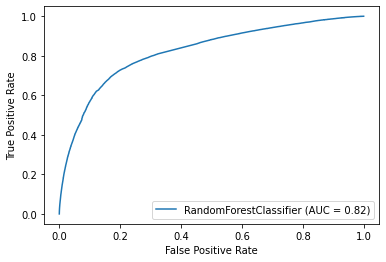

In [ ]:
plt.figure(figsize=(20,15))
rf_disp = plot_roc_curve(rf_best_model, X_val_tfvec, y_val)